In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
%matplotlib inline

In [2]:
api='P06YEE5KILX2R56D'
symbol='SQ'
r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={api}').json()


In [3]:
#Data Cleaning
df = pd.DataFrame(r['Time Series (Daily)'], dtype=float).transpose()
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2021-07-16,238.70,241.7700,234.4000,237.52,237.52,7879883.0,0.0,1.0
2021-07-15,239.83,241.6213,233.1100,235.16,235.16,7143467.0,0.0,1.0
2021-07-14,244.35,246.1899,238.4800,239.00,239.00,6188270.0,0.0,1.0
2021-07-13,243.35,247.4900,239.8400,241.43,241.43,6304526.0,0.0,1.0
2021-07-12,243.58,247.2200,241.7805,243.35,243.35,5722683.0,0.0,1.0


In [4]:
#Reversing index
df = df.reindex(index=df.index[::-1])
df.reset_index(level=0, inplace=True)
df.head()

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
0,2015-11-19,11.20,14.78,9.00,13.07,13.07,47466050.0,0.0,1.0
1,2015-11-20,13.92,14.05,12.50,12.85,12.85,16550328.0,0.0,1.0
2,2015-11-23,13.00,13.15,12.10,12.12,12.12,5172246.0,0.0,1.0
3,2015-11-24,12.00,12.23,11.52,12.02,12.02,4714682.0,0.0,1.0
4,2015-11-25,12.12,12.40,11.85,11.90,11.90,3583421.0,0.0,1.0


In [5]:
df = df.rename({
    'index': 'date',
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. adjusted close': 'adjusted_close',
    '6. volume': 'volume',
    '7. dividend amount': 'dividend_amount',
    '8. split coefficient': 'split_coefficient'},axis=1)
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2015-11-19,11.20,14.78,9.00,13.07,13.07,47466050.0,0.0,1.0
1,2015-11-20,13.92,14.05,12.50,12.85,12.85,16550328.0,0.0,1.0
2,2015-11-23,13.00,13.15,12.10,12.12,12.12,5172246.0,0.0,1.0
3,2015-11-24,12.00,12.23,11.52,12.02,12.02,4714682.0,0.0,1.0
4,2015-11-25,12.12,12.40,11.85,11.90,11.90,3583421.0,0.0,1.0


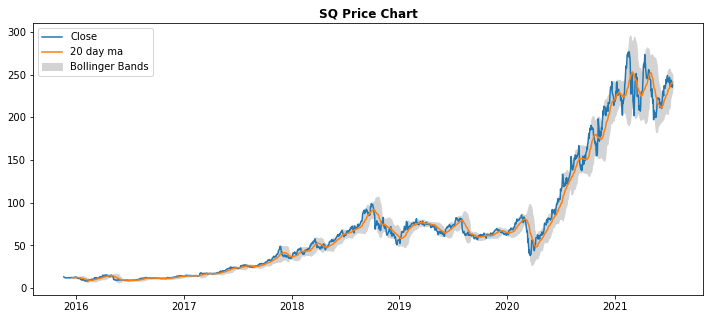

In [6]:
#Building Bollinger Bands
df['ma_20']=df['close'].rolling(20).mean()
df['std'] = df['close'].rolling(20).std()
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

plt.figure(figsize=(12,5))

x_axis = df['date']

plt.plot(x_axis, df['close'], label = 'Close')
plt.plot(df['date'], df['ma_20'], label = '20 day ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('SQ Price Chart', fontweight="bold")
plt.legend()


(0.0, 100.0)

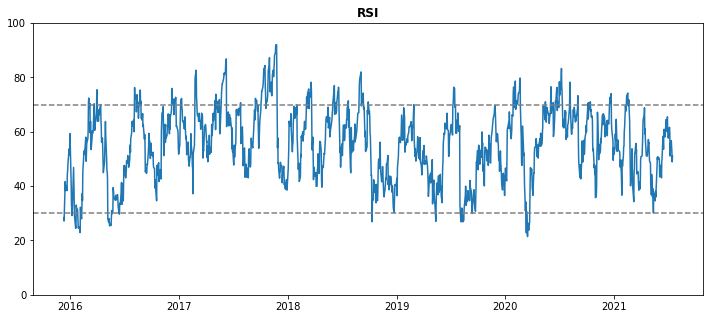

In [7]:
#Caclulating RSI

import talib
df['rsi'] = talib.RSI(df["close"])
plt.figure(figsize=(12,5))

x_axis = df['date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI', fontweight="bold")
plt.ylim([0, 100])

In [8]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

In [9]:
def backtest_dataframe(df):
    position = 0
    net_profit = 0
    percentage_change = []
    df['buy_date'] = ''
    df['sell_date'] = ''

    for i in df.index:
        close = df["close"][i]
        date = df['date'][i]

        # Buy action
        if df["signal"][i] == 1:
            if(position == 0):
                buy_price = close
                position = 1
                df.at[i, 'buy_date'] = date
                print(f"Buying at {str(buy_price)} on {str(date)}")

        # Sell action
        elif (df["signal"][i] == -1):
            if(position == 1):
                sell_price = close
                bought = 0
                position = 0
                df.at[i, 'sell_date'] = date
                print(f"Selling at {str(sell_price)} on {str(date)}")

                # Get percentage change of trade
                pc = (sell_price/buy_price-1)*100
                percentage_change.append(pc)
                net_profit += (sell_price - buy_price)

    # Calculate trade statistics
    gains = 0
    ng = 0
    losses = 0
    nl = 0
    totalR = 1

    for i in percentage_change:
        if(i > 0):
            gains += i
            ng += 1
        else:
            losses += i
            nl += 1
        totalR = totalR * ((i/100)+1)

    totalR = round((totalR-1)*100, 2)

    if(ng > 0 or nl > 0):
        win_rate = round((ng/(ng+nl))*100, 2)
    else:
        win_rate = 0

    print()
    print('Evaluation Metrics:')
    print('-----------------------------------')
    print(f"Number of Trades: {ng+nl}")
    print(f"Number of Gains: {ng}")
    print(f"Number of Losses: {nl}")
    print(f"Total Returns: {totalR}%")
    print(f"Win Rate: {win_rate}%")
    

In [10]:
backtest_dataframe(df)

Buying at 11.31 on 2016-01-08 00:00:00
Selling at 12.25 on 2016-03-03 00:00:00
Buying at 9.85 on 2016-05-09 00:00:00
Selling at 11.15 on 2016-08-05 00:00:00
Buying at 73.97 on 2018-10-12 00:00:00
Selling at 79.44 on 2019-07-11 00:00:00
Buying at 64.6 on 2019-08-06 00:00:00
Selling at 76.16 on 2020-01-29 00:00:00
Buying at 53.57 on 2020-03-12 00:00:00
Selling at 87.72 on 2020-06-04 00:00:00

Evaluation Metrics:
-----------------------------------
Number of Trades: 5
Number of Gains: 5
Number of Losses: 0
Total Returns: 154.2%
Win Rate: 100.0%


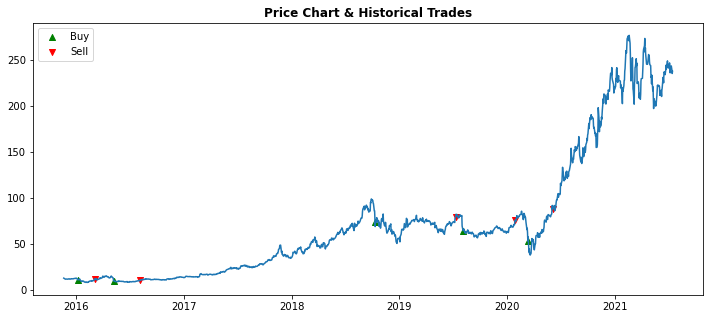

In [11]:
plt.figure(figsize=(12,5))

plt.plot(df['date'], df['close'])
plt.scatter(df[(df['signal'] == 1)]['buy_date'], df[(df['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df[(df['signal'] == -1)]['sell_date'], df[(df['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()